In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle
from tensorflow import keras
from ipywidgets import interactive


from sklearn.model_selection import train_test_split 
from sklearn import preprocessing as pp

# Methoden & Technieken

## Deep Boltzmann Machines

9 Jan 2023

Deze slides zijn gebaseerd op
- Hoofdstuk 11 van *Hands-on unsupervised learning in Python* van Patel
- Hoofdstuk 20 van [deeplearningbook.org](deeplearningbook.org)
- Salakhutdinov, R. & Hinton, G.. (2009). Deep Boltzmann Machines. <i>Proceedings of the Twelth International Conference on Artificial Intelligence and Statistics</i>, in <i>Proceedings of Machine Learning Research</i> ( https://proceedings.mlr.press/v5/salakhutdinov09a.html )


De code in dit notebook is aangepast uit
https://github.com/aapatel09/handson-unsupervised-learning/blob/master/11_dbns.ipynb

### Inhoud
- Herhaling RBMs
- Deep Boltzmann Machines
- Voorbeeld: DBM op MNIST data

### Herhaling: Restricted Boltzmann Machines

Een RBM is een *undirected graphical model* met
- Één zichtbare laag (de invoer)
- Één verborgen laag
- Correlaties tussen nodes in verschillende lagen
- Geen correlaties tussen nodes in dezelfde laag

Dit correspondeert met de volgende kansverdeling
$$
p(\vec{v}, \vec{h}) = exp(-E(\vec{v},\vec{h})),
$$
met als energie
$$
E(\vec{v},\vec{h}) = - \vec{a} \cdot \vec{v} - \vec{b} \cdot \vec{h} - \vec{v}\cdot W \vec{h}.
$$



#### Het model

De volledige kansverdeling is niet handig om mee te werken, belangrijk zijn:

- De forward pass
$$
p(h_j = 1 | \vec{v}) = \sigma(b_j + \sum v_i W_{ij})
$$
- De backward pass
$$
p(v_i = 1 | \vec{h}) = \sigma(a_i + \sum W_{ij} h_j)
$$
met $\sigma(x) = 1/(1+e^{-x})$ de gebruikelijke sigmoid functie.

#### Contrastive Divergence

De parameters ($W_{ij}$, $a_i$ en $b_j$), worden gevonden door de *log-likelihood* te maximaliseren met gradient ascend. Dit komt neer op de marginale kans $p(\vec{v})$ te maximaliseren. Dit geeft onder andere de volgende update regel voor de gewichten $W_{ij}$:

$$
\Delta W_{ij} = r \Big( \underbrace{\mathbb{E}[v_i h_j | \vec{v}]}_{data} - \underbrace{\mathbb{E}[v_i h_j]}_{model} \Big)
$$

met $r$ de *learning rate*. 

Probleem: om $\mathbb{E}[v_i h_j]$ exact uit te rekenen is een sommatie over alle mogelijkheden voor $\vec{v}$ en $\vec{h}$ nodig. Dit zijn exponentieel veel termen. Deze verwachtingswaarde word benaderd met de *Markov Chain Monte Carlo* methode.

#### Toepassingen RBMs

- Het is een *generatief* model, het modelleert een kansverdeling waaruit vervolgens getrokken kan worden.

- Het is een *unsupervised* model dat patronen in de data leert. Deze *features* (de hidden nodes) kunnen vervolgens als invoer voor andere modellen gebruikt worden.

### Deep Boltzmann Machines

Het idee van een DBM is dat de *features* van een RBM gebruikt worden als invoer voor een volgende RBM, en zo een paar lagen diep.

- In feite is dit een Boltzman Machine met een zwakkere restrictie dan een RBM, er mogen nu wel correlaties zijn tussen *hidden nodes*, maar niet in dezelfde laag.

- De diepere lagen leren meer en meer abstracte features.

Voordeel is dat deze lagen één voor één getraind kunnen worden. Dit maakt het een van de historisch eerste *deep learning* modellen die efficiënt getraind kon worden.

Het trainen van een DBM is een eerste stap in het trainen van een *Deep Belief Network* (les donderdag.)

In [2]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
X_train = X_train.reshape((60000,-1)).astype("float32") / 255
X_test = X_test.reshape((10000,-1)).astype("float32") / 255

X_train, X_validation,y_train,  y_validation = train_test_split(X_train, y_train, test_size = 10000, random_state = 2023)

# Verify shape of datasets
print("Shape of X_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of X_validation: ", X_validation.shape)
print("Shape of y_validation: ", y_validation.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_test: ", y_test.shape)

Shape of X_train:  (50000, 784)
Shape of y_train:  (50000,)
Shape of X_validation:  (10000, 784)
Shape of y_validation:  (10000,)
Shape of X_test:  (10000, 784)
Shape of y_test:  (10000,)


In [3]:
# Create Pandas DataFrames from the datasets
train_index = range(0,len(X_train))
validation_index = range(len(X_train),len(X_train)+len(X_validation))
test_index = range(len(X_train)+len(X_validation), \
                   len(X_train)+len(X_validation)+len(X_test))

X_train = pd.DataFrame(data=X_train,index=train_index)
y_train = pd.Series(data=y_train,index=train_index)

X_validation = pd.DataFrame(data=X_validation,index=validation_index)
y_validation = pd.Series(data=y_validation,index=validation_index)

X_test = pd.DataFrame(data=X_test,index=test_index)
y_test = pd.Series(data=y_test,index=test_index)

In [4]:
def plot_digit(X, y, example, ax):
    label = y.loc[example]
    image = X.loc[example,:].values.reshape([28,28])
    ax.imshow(image, cmap=plt.get_cmap('gray'))
    ax.set_axis_off()

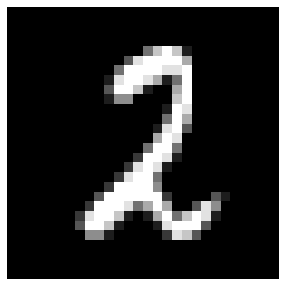

In [5]:
# View the first digit
fig = plt.figure(figsize = (5,5))
ax = fig.subplots(1,1)
plot_digit(X_train, y_train, 0, ax)
plt.show()

In [6]:
def one_hot(series):
    label_binarizer = pp.LabelBinarizer()
    label_binarizer.fit(range(max(series)+1))
    return label_binarizer.transform(series)

def reverse_one_hot(originalSeries, newSeries):
    label_binarizer = pp.LabelBinarizer()
    label_binarizer.fit(range(max(originalSeries)+1))
    return label_binarizer.inverse_transform(newSeries)

In [7]:
# Create one-hot vectors for the labels
y_train_oneHot = one_hot(y_train)
y_validation_oneHot = one_hot(y_validation)
y_test_oneHot = one_hot(y_test)

In [8]:
# Make code compatible with v1 of TF
tf.compat.v1.disable_eager_execution()

In [9]:
# Define RBM class
class RBM(object):
    
    def __init__(self, input_size, output_size, 
                 learning_rate, epochs, batchsize):
        # Define hyperparameters
        self._input_size = input_size
        self._output_size = output_size
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batchsize = batchsize
        
        # Initialize weights and biases using zero matrices
        self.w = np.zeros([input_size, output_size], dtype=np.float32)
        self.hb = np.zeros([output_size], dtype=np.float32)
        self.vb = np.zeros([input_size], dtype=np.float32)

    def prob_h_given_v(self, visible, w, hb):
        return tf.nn.sigmoid(tf.matmul(visible, w) + hb)

    def prob_v_given_h(self, hidden, w, vb):
        return tf.nn.sigmoid(tf.matmul(hidden, tf.transpose(w)) + vb)
    
    def sample_prob(self, probs):
        return tf.nn.relu(tf.sign(probs - tf.compat.v1.random_uniform(tf.shape(probs))))

    def train(self, X):
        _w = tf.compat.v1.placeholder(tf.float32, [self._input_size, self._output_size])
        _hb = tf.compat.v1.placeholder(tf.float32, [self._output_size])
        _vb = tf.compat.v1.placeholder(tf.float32, [self._input_size])
        
        prv_w = np.zeros([self._input_size, self._output_size], dtype=np.float32)
        prv_hb = np.zeros([self._output_size], dtype=np.float32)
        prv_vb = np.zeros([self._input_size], dtype=np.float32)
        
        cur_w = np.zeros([self._input_size, self._output_size], dtype=np.float32)
        cur_hb = np.zeros([self._output_size], dtype=np.float32)
        cur_vb = np.zeros([self._input_size], dtype=np.float32)
        
        v0 = tf.compat.v1.placeholder(tf.float32, [None, self._input_size])
        h0 = self.sample_prob(self.prob_h_given_v(v0, _w, _hb))
        v1 = self.sample_prob(self.prob_v_given_h(h0, _w, _vb))
        h1 = self.prob_h_given_v(v1, _w, _hb)
        
        positive_grad = tf.matmul(tf.transpose(v0), h0)
        negative_grad = tf.matmul(tf.transpose(v1), h1)
        
        update_w = _w + self.learning_rate * \
            (positive_grad - negative_grad) / tf.cast(tf.shape(v0)[0], tf.float32)
        update_vb = _vb +  self.learning_rate * tf.reduce_mean(v0 - v1, 0)
        update_hb = _hb +  self.learning_rate * tf.reduce_mean(h0 - h1, 0)
        
        err = tf.reduce_mean(tf.square(v0 - v1))
        
        error_list = []
        
        with tf.compat.v1.Session() as sess:
            sess.run(tf.compat.v1.global_variables_initializer())
            
            for epoch in range(self.epochs):
                for start, end in zip(range(0, len(X), \
                        self.batchsize),range(self.batchsize,len(X), \
                                              self.batchsize)):
                    batch = X[start:end]
                    cur_w = sess.run(update_w, feed_dict={v0: batch, \
                                    _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    cur_hb = sess.run(update_hb, feed_dict={v0: batch, \
                                    _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    cur_vb = sess.run(update_vb, feed_dict={v0: batch, \
                                    _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    prv_w = cur_w
                    prv_hb = cur_hb
                    prv_vb = cur_vb
                error = sess.run(err, feed_dict={v0: X, \
                                _w: cur_w, _vb: cur_vb, _hb: cur_hb})
                if epoch%10 == 0:
                    print(f'Epoch: {epoch} reconstruction error: {error}')
                error_list.append(error)
            self.w = prv_w
            self.hb = prv_hb
            self.vb = prv_vb
            return error_list

    def rbm_output(self, X):
        
        input_X = tf.constant(X)
        _w = tf.constant(self.w)
        _hb = tf.constant(self.hb)
        _vb = tf.constant(self.vb)
        out = tf.nn.sigmoid(tf.matmul(input_X, _w) + _hb)
        hiddenGen = self.sample_prob(self.prob_h_given_v(input_X, _w, _hb))
        visibleGen = self.sample_prob(self.prob_v_given_h(hiddenGen, _w, _vb))
        with tf.compat.v1.Session() as sess:
            sess.run(tf.compat.v1.global_variables_initializer())
            return sess.run(out), sess.run(visibleGen), sess.run(hiddenGen)
        
    def show_features(self, shape, suptitle, count=-1):
        maxw = np.amax(self.w.T)
        minw = np.amin(self.w.T)
        count = self._output_size if count == -1 or count > \
                self._output_size else count
        ncols = count if count < 14 else 14 
        nrows = count//ncols
        nrows = nrows if nrows > 2 else 3
        fig = plt.figure(figsize=(ncols, nrows), dpi=100)
        grid = Grid(fig, rect=111, nrows_ncols=(nrows, ncols), axes_pad=0.01)

        for i, ax in enumerate(grid):
            x = self.w.T[i] if i<self._input_size else np.zeros(shape)
            x = (x.reshape(1, -1) - minw)/maxw
            ax.imshow(x.reshape(*shape), cmap=mpl.cm.Greys)
            ax.set_axis_off()

        fig.text(0.5,1, suptitle, fontsize=20, horizontalalignment='center')
        fig.tight_layout()
        plt.show()
        return

In [10]:
# Since we are training, set input as training data
inputX = np.array(X_train)
inputX = inputX.astype(np.float32)

# Create list to hold our RBMs
rbm_list = []

# Define the parameters of the RBMs we will train
rbm_list.append(RBM(784,700,1.0,100,200))
rbm_list.append(RBM(700,600,1.0,100,200))
rbm_list.append(RBM(600,500,1.0,100,200))

In [11]:
## To make the output stable across runs
#tf.random.set_seed(2023)
#np.random.seed(2023)
#
#outputList = []
#error_list = []
##For each RBM in our list
#for i in range(0,len(rbm_list)):
#    print('RBM', i+1)
#    #Train a new one
#    rbm = rbm_list[i]
#    err = rbm.train(inputX)
#    error_list.append(err)
#    #Return the output layer
#    outputX, reconstructedX, hiddenX = rbm.rbm_output(inputX)
#    outputList.append(outputX)
#    inputX = hiddenX
#
#with open('DBM.pickle', mode = 'wb') as file:
#    pickle.dump([rbm_list, outputList, error_list], file)

In [12]:
with open('DBM.pickle', mode = 'rb') as file:
    rbm_list, outputList, error_list = pickle.load(file)

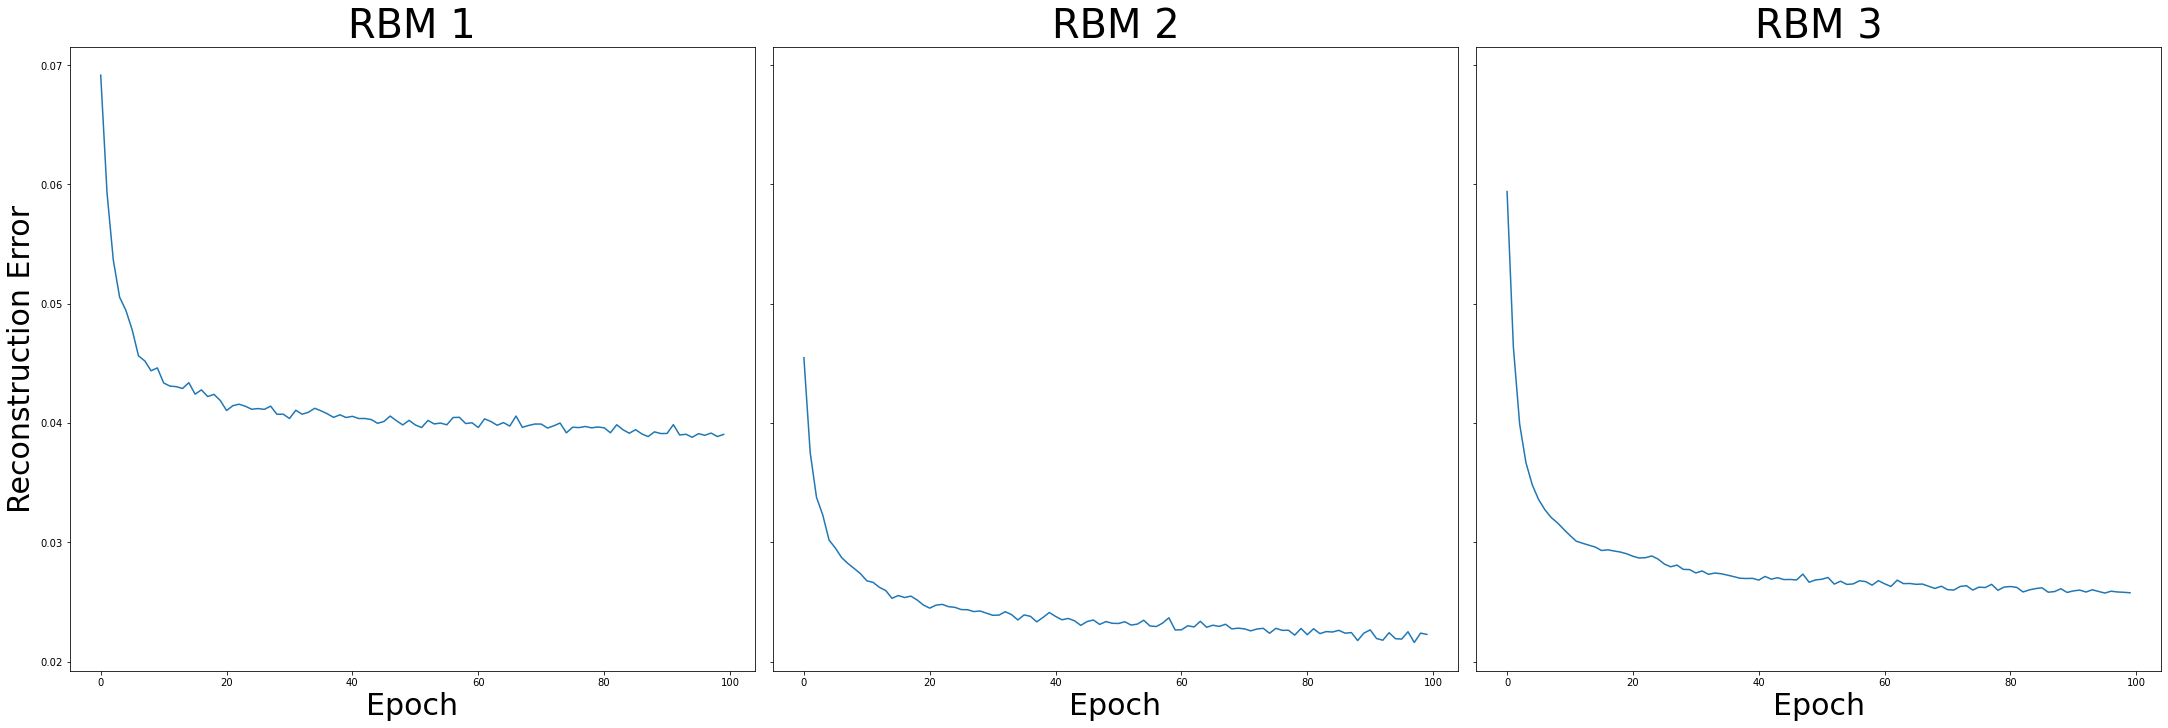

In [13]:
# Plot reconstruction errors
fig = plt.figure(figsize=(30,10), constrained_layout=True)
ax = fig.subplots(1,3,sharey=True)
for i, err in enumerate(error_list):
    pd.Series(err).plot(ax = ax[i], logy=False)
    ax[i].set_xlabel("Epoch", fontsize=30)
    ax[i].set_ylabel("Reconstruction Error", fontsize=30)
    ax[i].set_title(f'RBM {i+1}', fontsize=40)
plt.show()


In [14]:
# View generated images from the first RBM
inputX = np.array(X_train)
rbmOne = rbm_list[0]

outputX_rbmOne, reconstructedX_rbmOne, hiddenX_rbmOne = \
                            rbmOne.rbm_output(inputX)
reconstructedX_rbmOne = pd.DataFrame(data=reconstructedX_rbmOne, \
                                     index=X_train.index)


2023-01-09 10:41:19.575559: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Voorbeeld: DBM op MNIST

In [15]:
def plot_images(j):
    fig = plt.figure(figsize = (20,10), constrained_layout=True)
    ax = fig.subplots(1,2)
    example = j
    plot_digit(reconstructedX_rbmOne, y_train, example, ax[1])
    ax[1].set_title('Reconstructed Image', fontsize = 40)
    plot_digit(X_train, y_train, example, ax[0])
    ax[0].set_title('Original Image', fontsize = 40)
    
interactive(plot_images, j=(0,9))

interactive(children=(IntSlider(value=4, description='j', max=9), Output()), _dom_classes=('widget-interact',)…